## Лабораторная 4: восстановление плотности распределения

Данными в этом задании являются измерения некоторых проверочных параметров на конвейерах  сборки оборудования Bosh (см. [конкурс](https://www.kaggle.com/c/bosch-production-line-performance) «Bosch Production Line Performance» на Kaggle). 

Все исходные данные Bosh не помещаются в оперативную память компьютера, поэтому в файле `data.csv` — лишь некоторые признаки. Прочтите данные из файла `data.csv`. Целевым признаком здесь является `Response` — наличие брака в оборудовании. 

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("data.csv", delimiter=',')

## 1 
Постройте на одном графике два приближения к плотности распределения признака `L1_S24_F1846` для `Response = 0` и для `Response = 1`, используя одно из следующих ядер (номер ядра выберите по формуле: `(n mod 6) + 1`, где `n` — ваш номер в списке группы):

    1.	кусочно-постоянное (прямоугольное) -  tophat
    2.	гауссовское -  gaussian
    3.	линейное (треугольник) -  linear
    4.	косинусоидальное -  cosine
    5.	квадратичное (Епанечникова) -  epanechnikov
    6.	экспоненциальное -  exponential


In [5]:
from sklearn.neighbors import KernelDensity
import numpy as np

import matplotlib.pyplot as plt

*Help:*

    i0 = data['Response'] == 0
    kde0 = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(data.loc[i0, 'L1_S24_F1846'].values.reshape(-1, 1))
    X_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
    Dens0 = np.exp(kde0.score_samples(X_plot))  # score_samples возвращает логарифм плотности

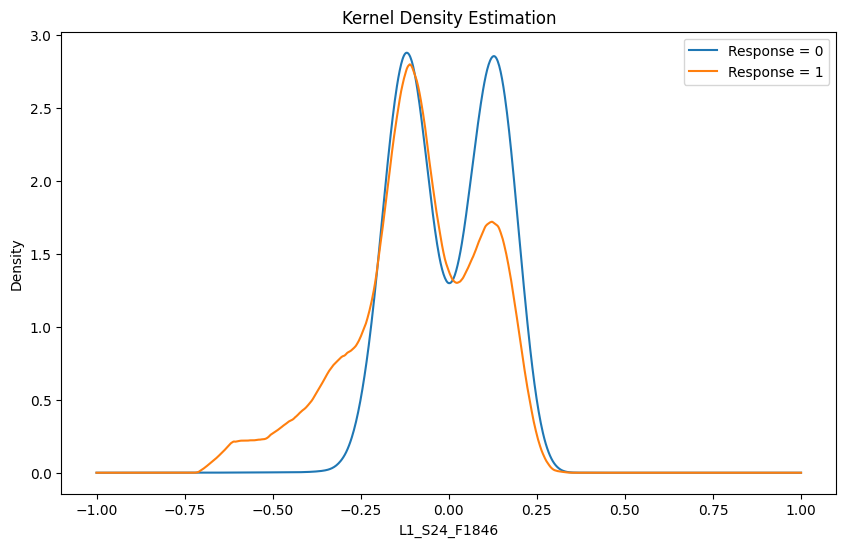

In [7]:

# Фильтрация данных по Response = 0
i0 = data['Response'] == 0
X0 = data.loc[i0, 'L1_S24_F1846'].values.reshape(-1, 1)

# Фильтрация данных по Response = 1
i1 = data['Response'] == 1
X1 = data.loc[i1, 'L1_S24_F1846'].values.reshape(-1, 1)

# Создание и обучение модели для Response = 0
kde0 = KernelDensity(kernel='linear', bandwidth=0.1).fit(X0)
X_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
dens0 = np.exp(kde0.score_samples(X_plot))

# Создание и обучение модели для Response = 1
kde1 = KernelDensity(kernel='linear', bandwidth=0.1).fit(X1)
dens1 = np.exp(kde1.score_samples(X_plot))

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(X_plot, dens0, label='Response = 0')
plt.plot(X_plot, dens1, label='Response = 1')
plt.xlabel('L1_S24_F1846')
plt.ylabel('Density')
plt.title('Kernel Density Estimation')
plt.legend()
plt.show()

Ответьте в комментариях на вопрос: является ли выборка хорошо разделимой по признаку  `L1_S24_F1846`?

In [ ]:
Оскільки, графіки надто схожі і перекриваються, це може вказувати на те, що вибірка не добре розділена за даною ознакою.

## 2

Разбейте выборку `data` на две равные части: тренировочную `dataTrain` и проверочную `dataTest`. 

In [ ]:
dataTrain = data.loc[0:data.shape[0] / 2, ].reset_index(drop=True)
dataTest = data.loc[data.shape[0] / 2:data.shape[0], ].reset_index(drop=True)

Пользуясь кросс-валидацией, подберите **для каждого класса `Response` (`r=0` и `r=1`)** значение ширины ядра `bandwidth`, при котором логарифм правдоподобия максимален на проверочной выборке.

*Help:*

    r = 0
    kde0 = KernelDensity(kernel='gaussian', bandwidth=0.05)
    kde0.fit(dataTrain.loc[dataTrain['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability0 = kde0.score_samples(dataTest.loc[dataTest['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability0[np.isinf(logProbability0)] = -100 # заменяем -бесконечность
    logLikehood0 = logProbability0.sum()
    print(logLikehood0)

In [8]:
from sklearn.model_selection import cross_val_score

# Разбиение выборки на тренировочную и проверочную части
dataTrain = data.loc[0:data.shape[0] // 2, ].reset_index(drop=True)
dataTest = data.loc[data.shape[0] // 2:data.shape[0], ].reset_index(drop=True)

# Подбор значения ширины ядра для каждого класса Response
bandwidth_values = [0.01, 0.05, 0.1, 0.5, 1.0] 

for r in [0, 1]:
    best_bandwidth = None
    best_log_likelihood = float('-inf')
    
    for bandwidth in bandwidth_values:
        # Создание и обучение модели с текущим значением ширины ядра
        kde = KernelDensity(kernel='linear', bandwidth=bandwidth)
        kde.fit(dataTrain.loc[dataTrain['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
        
        # Вычисление логарифма правдоподобия на проверочной выборке
        log_probability = kde.score_samples(dataTest.loc[dataTest['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
        log_probability[np.isinf(log_probability)] = -100  # Заменяем -бесконечность
        log_likelihood = log_probability.sum()
        
        # Обновление значения ширины ядра, если логарифм правдоподобия больше
        if log_likelihood > best_log_likelihood:
            best_bandwidth = bandwidth
            best_log_likelihood = log_likelihood
    
    # Вывод значения ширины ядра с максимальным логарифмом правдоподобия
    print(f"Best bandwidth for Response {r}: {best_bandwidth}, Log likelihood: {best_log_likelihood}")

Best bandwidth for Response 0: 0.05, Log likelihood: 21997.909755178684
Best bandwidth for Response 1: 0.05, Log likelihood: 114.80410633230642


### 3

Для найденных наилучших `bandwidth` вычислите `p(x|0)` и `p(x|1)` для тестовой выборки. 

In [9]:
predictionProbXafter0 = np.exp(kde0.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))
predictionProbXafter1 = np.exp(kde1.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))

По формуле Байеса найдите затем `p(0|x)` и `p(1|x)`. Отсортируйте все объекты тестовой выборки по возрастанию предсказанной вероятности `p(1|x)`, выведите на экран вероятности для последних 10 объектов и рассчитайте количество бракованных деталей среди последних 100 объектов в отсортированном ряду.

*Help:*
    
    ind = np.argsort(predictionProb1afterX) - сортировка, возвращающая индексы элементов
    print(predictionProb1afterX[ind[-10:]]) - вывод последних 10 элементов
    print(sum(dataTest.loc[ind[-100:],'Response'])) - количество бракованных среди 100 с максимальной вероятностью брака

In [10]:
p0_given_x = predictionProbXafter0 / (predictionProbXafter0 + predictionProbXafter1)
p1_given_x = predictionProbXafter1 / (predictionProbXafter0 + predictionProbXafter1)

ind = np.argsort(p1_given_x)
print(p1_given_x[ind[-10:]])

num_defective = sum(dataTest.loc[ind[-100:], 'Response'])
print(f"Number of defective items: {num_defective}")


[0.99234301 0.99241801 0.99241801 0.99302181 0.99302181 0.99306036
 0.99307083 0.99307083 0.9931541  0.9931541 ]
Number of defective items: 29
